In [307]:
%reset 
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import seaborn as sns


from process_lfps import butter_bandpass_filter, create_data_segments

sns.set(font_scale=2,style='whitegrid') 
pd.set_option('max_colwidth',100)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Plotting Place Fields on Linear Track

In [308]:
datapath = 'python_data_lintrack/'
files = os.listdir(datapath)
files = [f for f in files if not f.startswith('.')]

In [309]:
files

['posdf_day1_epoch2.csv', 'spikesdf_day1_epoch2.csv']

In [310]:
posdf = pd.read_csv(os.path.join(datapath,'posdf_day1_epoch2.csv'))
spikesdf = pd.read_csv(os.path.join(datapath,'spikesdf_day1_epoch2.csv'))

In [311]:
spikesdf['posindex_0ind'] = spikesdf[['posindex']] - 1

In [312]:
spikesdf

,spike_ts,x,y,hdir,posindex,cell_id,cell_type,posindex_0ind
0,3902.7383,103.35,133.90,0.625485,531,HPa_CA1_day1_epoch2_tet1_unitnum1,CA1Pyr,530
1,3905.7398,105.95,135.20,0.463648,621,HPa_CA1_day1_epoch2_tet1_unitnum1,CA1Pyr,620
2,3911.1145,109.85,100.10,-2.587285,783,HPa_CA1_day1_epoch2_tet1_unitnum1,CA1Pyr,782
3,3972.4770,108.55,124.80,0.039979,2622,HPa_CA1_day1_epoch2_tet1_unitnum1,CA1Pyr,2621
4,3972.4809,108.55,124.80,0.039979,2622,HPa_CA1_day1_epoch2_tet1_unitnum1,CA1Pyr,2621
...,...,...,...,...,...,...,...,...
41816,5029.8387,102.05,70.85,-1.642104,34317,HPa_iCA1_day1_epoch2_tet14_unitnum1,iCA1Pyrpr,34316
41817,5029.8457,102.05,70.85,-1.642104,34317,HPa_iCA1_day1_epoch2_tet14_unitnum1,iCA1Pyrpr,34316
41818,5033.2821,102.05,70.20,-1.639653,34420,HPa_iCA1_day1_epoch2_tet14_unitnum1,iCA1Pyrpr,34419
41819,5033.3140,102.70,70.20,-1.605265,34421,HPa_iCA1_day1_epoch2_tet14_unitnum1,iCA1Pyrpr,34420


In [313]:
posdf = posdf.dropna()

In [314]:
cell_labels = list(set(spikesdf['cell_id'].to_list()))

In [315]:
subcell = spikesdf[spikesdf['cell_id']==cell_labels[9]]

locinds = list(set(posdf.index) & set(subcell['posindex_0ind']))
locinds = sorted(locinds)
locinds = locinds[:-1]

x_spikes = posdf['x'].iloc[locinds]
y_spikes = posdf['y'].iloc[locinds]

In [316]:
set(subcell['cell_type'].to_list())

{'iCA1Pyr'}

error: a ratio exceeds 1


(0.0, 139.52575)

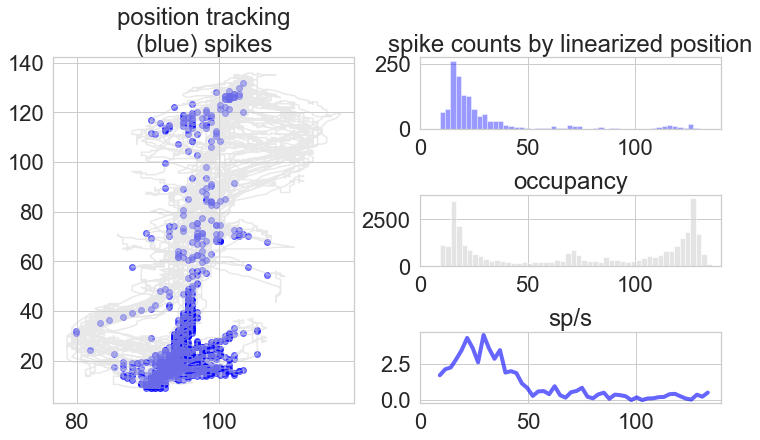

In [317]:
fig, axd = plt.subplot_mosaic([['left', 'upper right'],
                               ['left', 'middle right'],
                               ['left', 'lower right']
                              ],
                              figsize=(10, 6), constrained_layout=True)
binsize = 50

axd['left'].plot(posdf['x'],posdf['y'],color='lightgrey',alpha=0.5)
axd['left'].scatter(x_spikes,y_spikes,color='blue',alpha=0.5)
axd['left'].set_title('position tracking' + '\n' + '(blue) spikes')

sp_per_bin = axd['upper right'].hist(y_spikes,bins=binsize,alpha=0.4,color='blue')
axd['upper right'].set_title('spike counts by linearized position')
axd['upper right'].set_xlim(0,140)


occupancy_per_bin = axd['middle right'].hist(posdf['y'],bins=binsize,alpha=0.6,color='lightgrey')
axd['middle right'].set_title('occupancy')
axd['middle right'].set_xlim(0,140)

norm_spikes_per_bin = sp_per_bin[0] / (occupancy_per_bin[0] * np.median(np.diff(posdf['time'].values))) 

if np.where(sp_per_bin[0] / occupancy_per_bin[0] > 1):

    print('error: a ratio exceeds 1')

bin_edges = occupancy_per_bin[1]
axd['lower right'].plot(bin_edges[:-1],norm_spikes_per_bin,alpha=0.6,linewidth=4,color='blue')
axd['lower right'].set_title('sp/s')
axd['lower right'].set_xlim(0,)


Now, I: need to apply the cutoffs that people use to determine the time stamps corresponding to entrance into and exit from the place field for each cell. Storage options: 

- separate df per unique cell
- single df, with column labels indicating cell identity, entrance time, exit time

Currently leaning towards the second, to keep all the data for each day/epoch within a single folder?

- smooth fields first 
- find the local maximum (maxima)
- find the bins at which the frate decays to less than 10% of the maximum


Notes from Buzsaki Lab code: 
- minimum peak rate set at 2 Hz
- percent change between peak rate and start/end of field (set to 15%)
- remove field peaks with standard deviation > mean frate (unreliable)
- find center of mass: 
    
      while sum(meanRates(i,startfield:stopfield)) - sum(meanRates(i,startfield:com)) > sum(meanRates(i,startfield:stopfield))./2: 
            fields{i}{fieldCount}.COM = com;
            com = com + 1 
      end
      fieldCount = fieldCount + 1

In [318]:
#alternative detection code, to deal with multiple frake peaks
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

s=norm_spikes_per_bin
sm = gaussian_filter1d(s, 2)

if np.mean(sm) <=3:
    
    thresh_peak = 3 #Hz, min frate to be considered a peak of field
    stdevs = 2 # number of std above mean frate to consider field
    thresh_pct = 0.15 #percent of edge relative to max peak
    
    

    #find the max peak
    peaks, _ = find_peaks(sm, height = thresh_peak)
    vanillapeaks = np.where(sm == max(sm))
    
    if sm[vanillapeaks] > thresh_peak:
        
        locpeaks = np.hstack((vanillapeaks[0], peaks))
        peaks = np.array(sorted(list(set(locpeaks))))
    
    peaks = [i for i in peaks if sm[i] >= np.mean(sm) + np.std(sm)]
    
                
    left_edges = []
    right_edges = []
    
    if len(peaks) > 0:

        
        for ind, candidate in enumerate(peaks): 

            
            if (sm[candidate] > thresh_peak) & (sm[candidate] >= np.mean(sm) + (stdevs * np.std(sm))):
                
                #generate a gaussian centered around candidate peak
                xvals = np.linspace(0,len(sm),len(sm))
                mu = candidate
                sigma = 7 # num standard deviations from peak
                gauss = gaussian(xvals,mu,sigma)

                gauss_2deriv = np.diff(np.diff(gauss))
                gauss_peaks = find_peaks(gauss_2deriv)
                gauss_peaks = gauss_peaks[0]
                
                #account for a field that decays right at the edge of the maze
                if len(gauss_peaks) == 1:
                    
                    if gauss_peaks > candidate:
                        
                        gauss_peaks = np.hstack((0,gauss_peaks))
                        
                    elif gauss_peaks < candidate: 
                        
                        gauss_peaks = np.hstack((gauss_peaks,len(sm)))
                
                for boundary in gauss_peaks:
                    
                    if boundary < candidate:
                        
                        left_max = boundary
                        
                        search_snippet = sm[left_max:candidate]
                        height_to_find = thresh_pct*sm[candidate]
                        abs_height_diffs = np.abs(search_snippet - height_to_find)
                        
                        left_edge = abs_height_diffs.argmin() + left_max
                        
                    if boundary > candidate:
                        
                        right_max = boundary
                        
                        search_snippet = sm[candidate:right_max]
                        height_to_find = thresh_pct*sm[candidate]
                        abs_height_diffs = np.abs(search_snippet - height_to_find)
                        
                        right_edge = abs_height_diffs.argmin() + candidate
                        
                    if boundary == candidate:
                        
                        print('edge field')
                        
                        if 'left_edge' in locals():
                            
                            right_edge = boundary
                            
                        if 'right_edge' in locals():
                            
                            left_edge = boundary
                            
                left_edges.append(left_edge)
                right_edges.append(right_edge)
                        
                                       

In [322]:
# plt.plot(gauss)
# plt.plot(sm)
# plt.vlines(x=peaks[0],ymin=0,ymax=3.5,color='k')
# plt.vlines(x=gauss_peaks[0],ymin=0,ymax=3.5,color='k',alpha=0.6,linestyle='--')

# plt.vlines(x=left_edge,ymin=0,ymax=3.5,color='blue')
# plt.vlines(x=right_edge,ymin=0,ymax=3.5,color='blue')

In [320]:
sm[right_edges]/sm[candidate], sm[left_edges]/sm[candidate]

(array([0.22113285]), array([0.60587385]))

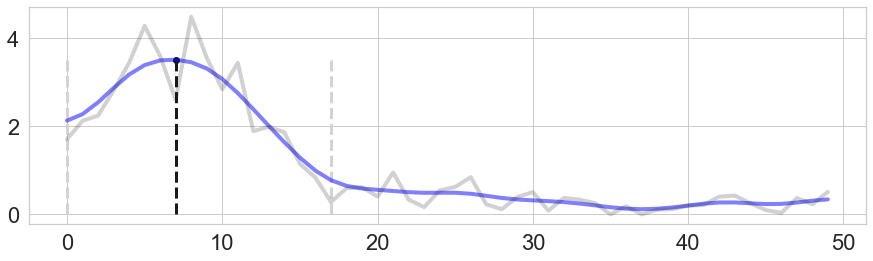

In [321]:
fig, ax = plt.subplots(figsize=(15,4))

ax.plot(sm,linewidth=4,alpha=0.5,color='blue')
ax.plot(s,linewidth=4,alpha=0.2,color='k')
ax.scatter(peaks, sm[peaks],color='k')
ax.vlines(x = peaks, ymin = 0, ymax = max(sm), color = 'k', linewidth = 3, linestyle = "--")
ax.vlines(x = [left_edges, right_edges], ymin = 0, ymax = max(sm), color = 'lightgrey', linewidth = 3, linestyle = "--")
       

Function below synthesizes the detection code I prototyped above.

In [323]:
from math import nan
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def get_field_bin_edges(sm,thresh_peak,stdevs,thresh_pct): 
    """sm: list/array, smoothed firing rate curve
    thresh_peak: scalar, mean firing rate threhsold for considering cells, cells considered will
                        have mean frate less than or equal to this value
    stdevs: scalar, number of standard deviations above the mean frate to consider legit field
    thresh_peak: scalar, minimum height of the firing rate peak to be considered a field
    thresh_pct: scalar, proportion of edge-of-field to peak-of-field to be considered an entrance or exit of field
    """
    
    if np.mean(sm) <=3:
    
        thresh_peak = 3 #Hz, min frate to be considered a peak of field
        stdevs = 2 # number of std above mean frate to consider field
        thresh_pct = 0.10 #percent of edge relative to max peak

        #find the max peak
        peaks, _ = find_peaks(sm, height = thresh_peak)
        vanillapeaks = np.where(sm == max(sm))

        if sm[vanillapeaks] > thresh_peak:

            locpeaks = np.hstack((vanillapeaks[0], peaks))
            peaks = np.array(sorted(list(set(locpeaks))))

        peaks = [i for i in peaks if sm[i] >= np.mean(sm) + np.std(sm)]

        left_edges = []
        right_edges = []
        
        left_edge = []
        right_edge = []

        if len(peaks) > 0:

            for ind, candidate in enumerate(peaks): 
                
                if (sm[candidate] > thresh_peak) & (sm[candidate] >= np.mean(sm) + (stdevs * np.std(sm))):

                    #generate a gaussian centered around candidate peak
                    xvals = np.linspace(0,len(sm),len(sm))
                    mu = candidate
                    sigma = 7 # num standard deviations from peak
                    gauss = gaussian(xvals,mu,sigma)

                    #use second derivative to find the points at which the ideal gaussian tapers off
                    gauss_2deriv = np.diff(np.diff(gauss))
                    gauss_peaks = find_peaks(gauss_2deriv)
                    gauss_peaks = gauss_peaks[0]
                    
                    #account for a field that decays right at the edge of the maze
                    if len(gauss_peaks) == 1:
                    
                        if gauss_peaks > candidate:

                            gauss_peaks = np.hstack((0,gauss_peaks))

                        elif gauss_peaks < candidate: 

                            gauss_peaks = np.hstack((gauss_peaks,len(sm)))

                    #all this to restrict the search for the actual field's taper points
                    for boundary in gauss_peaks:

                        if boundary < candidate:

                            left_max = boundary

                            search_snippet = sm[left_max:candidate]
                            height_to_find = thresh_pct*sm[candidate]
                            abs_height_diffs = np.abs(search_snippet - height_to_find)

                            left_edge = abs_height_diffs.argmin() + left_max

                        elif boundary > candidate:

                            right_max = boundary

                            search_snippet = sm[candidate:right_max]
                            height_to_find = thresh_pct*sm[candidate]
                            abs_height_diffs = np.abs(search_snippet - height_to_find)

                            right_edge = abs_height_diffs.argmin() + candidate

                        elif boundary == candidate:

                            print('edge field')

                            if 'left_edge' in locals():

                                right_edge = boundary

                            if 'right_edge' in locals():

                                left_edge = boundary

                    left_edges.append(left_edge)
                    right_edges.append(right_edge)

    return left_edges, peaks, right_edges



## Find & store entrance and exit position bins and times

These will be subject to some constraints: 
- velocity, animal should be running into/out of the field, not dallying at a position bin
- head direction, especially for fields that lie right at the track edges -- for these fields, I might only be able to consider the field entrance

In [324]:
datapath = 'python_data_lintrack/'

posdf = pd.read_csv(os.path.join(datapath,'posdf_day1_epoch2.csv'))
spikesdf = pd.read_csv(os.path.join(datapath,'spikesdf_day1_epoch2.csv'))

spikesdf['posindex_0ind'] = spikesdf[['posindex']] - 1 #account for python 0-indexing, which matlab doesn't do
posdf = posdf.dropna()

cell_labels = list(set(spikesdf['cell_id'].to_list()))

pos_binning = 50
pos_bineds = np.linspace(posdf['y'].min(),posdf['y'].max(),pos_binning)
labels = np.linspace(0,pos_binning-1,pos_binning-1)
labels = [int(i) for i in labels]
posdf['y_binned'] = pd.cut(posdf['y'],
                           labels=labels,
                           bins=pos_bineds,
                           include_lowest=True
                          )

thresh_mean_frate = 3 #Hz
thresh_peak = 2 #Hz
thresh_pct = 0.10 #proportion edge to peak frate

edges = []
for cell in cell_labels:
   
    subcell = spikesdf[spikesdf['cell_id']==cell]
    cell_type = list(set(subcell['cell_type'].to_list()))
    
    if not cell_type[0] == 'CA1Int':
    
        locinds = list(set(posdf.index) & set(subcell['posindex_0ind']))
        locinds = sorted(locinds)
        locinds = locinds[:-1]

        x_spikes = posdf['x'].iloc[locinds]
        y_spikes = posdf['y'].iloc[locinds]

        sp_per_bin = plt.hist(y_spikes,bins=pos_binning,alpha=0.4,color='blue')

        occupancy_per_bin = plt.hist(posdf['y'],bins=pos_binning,alpha=0.6,color='lightgrey')

        norm_spikes_per_bin = sp_per_bin[0] / (occupancy_per_bin[0] * np.median(np.diff(posdf['time'].values))) 


        s=norm_spikes_per_bin
        sm = gaussian_filter1d(s, 2) 

        left_edges, maxpeaks, right_edges = get_field_bin_edges(sm,thresh_mean_frate,thresh_peak,thresh_pct)

        if (len(left_edges) > 0) & (len(right_edges) > 0):

            d = {'cell_id': np.repeat(cell, len(maxpeaks)), 
                 'cell_type': np.repeat(cell_type, len(maxpeaks)), 
                 'left_edge_posbin': left_edges, 
                 'peak_posbin': maxpeaks, 
                 'right_edge_posbin': right_edges, 

                }

            edges.append(pd.DataFrame(d))

        plt.close()
    
edges_df = pd.concat(edges)


edge field


In [325]:
edges_df

,cell_id,cell_type,left_edge_posbin,peak_posbin,right_edge_posbin
0,HPa_CA1_day1_epoch2_tet4_unitnum1,CA1Pyr,15,24,33
0,HPa_iCA1_day1_epoch2_tet11_unitnum2,iCA1Pyrp,0,2,12
0,HPa_iCA1_day1_epoch2_tet9_unitnum1,iCA1Pyr,0,7,17
0,HPa_iCA1_day1_epoch2_tet14_unitnum1,iCA1Pyrpr,0,4,14
0,HPa_CA1_day1_epoch2_tet4_unitnum2,CA1Pyr,0,0,10


In [326]:
edges_df.reset_index()

,index,cell_id,cell_type,left_edge_posbin,peak_posbin,right_edge_posbin
0,0,HPa_CA1_day1_epoch2_tet4_unitnum1,CA1Pyr,15,24,33
1,0,HPa_iCA1_day1_epoch2_tet11_unitnum2,iCA1Pyrp,0,2,12
2,0,HPa_iCA1_day1_epoch2_tet9_unitnum1,iCA1Pyr,0,7,17
3,0,HPa_iCA1_day1_epoch2_tet14_unitnum1,iCA1Pyrpr,0,4,14
4,0,HPa_CA1_day1_epoch2_tet4_unitnum2,CA1Pyr,0,0,10


Now, we need to find all the time stamps per cell that correspond to crossing these entrances and exits. 

It might be important that the rat is actively _crossing_ and not just _occupying_ these position bins though, so I'll also need velocity at these times to meet the criteria for crossing.

In [405]:
subvel = posdf[posdf['velocity'] > 2]
edges = ['left_edge', 'right_edge']
hdir = ['down','up']

cell_labels = list(set(edges_df['cell_id'].to_list()))

times = []
for cell in cell_labels:
    
    subedge = edges_df[edges_df['cell_id'] == cell]
    
    celltype = subedge['cell_type'].values

    for edge in edges: 
        edgeval = subedge[edge + '_posbin'].values[0]

        for hd in hdir: 
            
            if hd == 'down':
                
                subedgehdir = subvel[(subvel['y_binned']==edgeval) & (subvel['hdir'] < 0)]
                
            if hd == 'up':
                
                subedgehdir = subvel[(subvel['y_binned']==edgeval) & (subvel['hdir'] > 0)]

            ts = subedgehdir['time'].to_list()
            
            if len(ts) > 0:

                d = {'cell_id': np.repeat(cell,len(ts)),
                     'cell_type': np.repeat(celltype,len(ts)), 
                     'time': ts,
                     'edgecross': np.repeat(edge,len(ts)), 
                     'crossdir': np.repeat(hd,len(ts)),
                    }

                times.append(pd.DataFrame(d))

times_df = pd.concat(times)

In [406]:
times_df

,cell_id,cell_type,time,edgecross,crossdir
0,HPa_CA1_day1_epoch2_tet4_unitnum1,CA1Pyr,3917.1520,left_edge,down
1,HPa_CA1_day1_epoch2_tet4_unitnum1,CA1Pyr,3917.1854,left_edge,down
2,HPa_CA1_day1_epoch2_tet4_unitnum1,CA1Pyr,3917.2187,left_edge,down
3,HPa_CA1_day1_epoch2_tet4_unitnum1,CA1Pyr,3917.2521,left_edge,down
4,HPa_CA1_day1_epoch2_tet4_unitnum1,CA1Pyr,3917.2853,left_edge,down
...,...,...,...,...,...
109,HPa_iCA1_day1_epoch2_tet9_unitnum1,iCA1Pyr,4953.7861,right_edge,up
110,HPa_iCA1_day1_epoch2_tet9_unitnum1,iCA1Pyr,4953.8193,right_edge,up
111,HPa_iCA1_day1_epoch2_tet9_unitnum1,iCA1Pyr,4953.8527,right_edge,up
112,HPa_iCA1_day1_epoch2_tet9_unitnum1,iCA1Pyr,4953.8860,right_edge,up


In [431]:
edges_df

,cell_id,cell_type,left_edge_posbin,peak_posbin,right_edge_posbin
0,HPa_CA1_day1_epoch2_tet4_unitnum1,CA1Pyr,15,24,33
0,HPa_iCA1_day1_epoch2_tet11_unitnum2,iCA1Pyrp,0,2,12
0,HPa_iCA1_day1_epoch2_tet9_unitnum1,iCA1Pyr,0,7,17
0,HPa_iCA1_day1_epoch2_tet14_unitnum1,iCA1Pyrpr,0,4,14
0,HPa_CA1_day1_epoch2_tet4_unitnum2,CA1Pyr,0,0,10


In [432]:
subcell = times_df[times_df['cell_id'] == 'HPa_CA1_day1_epoch2_tet4_unitnum1']

In [433]:
subcell = subcell.sort_values(by = ['time'])

In [434]:
subcell

,cell_id,cell_type,time,edgecross,crossdir
0,HPa_CA1_day1_epoch2_tet4_unitnum1,CA1Pyr,3891.3313,left_edge,up
1,HPa_CA1_day1_epoch2_tet4_unitnum1,CA1Pyr,3891.3647,left_edge,up
2,HPa_CA1_day1_epoch2_tet4_unitnum1,CA1Pyr,3894.3334,left_edge,up
3,HPa_CA1_day1_epoch2_tet4_unitnum1,CA1Pyr,3894.3667,left_edge,up
4,HPa_CA1_day1_epoch2_tet4_unitnum1,CA1Pyr,3894.4000,left_edge,up
...,...,...,...,...,...
131,HPa_CA1_day1_epoch2_tet4_unitnum1,CA1Pyr,4974.0687,right_edge,up
132,HPa_CA1_day1_epoch2_tet4_unitnum1,CA1Pyr,4974.1020,right_edge,up
115,HPa_CA1_day1_epoch2_tet4_unitnum1,CA1Pyr,4997.4541,right_edge,down
116,HPa_CA1_day1_epoch2_tet4_unitnum1,CA1Pyr,4997.4873,right_edge,down


In [435]:
# keep only timestamps between which there are large gaps (greater than pos dt)

#max time difference between position samples
# posdt = np.max(np.diff(posdf['time'].values))

#the indices of the dataframe are in a perfect order to identify rows that must be removed
#any time the difference between row numbers is negative, a new block of time stamps greater than position 
#sampling rate has started. keep the last time stamp of each block of time stamps

rows_to_keep = np.where(np.diff(subcell.index)<0)
rows_to_keep = np.hstack((rows_to_keep[0], subcell.shape[0]-1))

tmp = subcell.iloc[rows_to_keep]

#now, have to keep only the allowable sequences: 
#.   - right_edge + down followed by left_edge + down 
#.   - left_edge + up followed by right_edge + up

field_traverse_counter = 0
field_times = []
for i in np.arange(1,tmp.shape[0]): 
    
    row1 = i-1
    row2 = i
    
    head_dir1 = tmp['crossdir'].iloc[row1]
    head_dir2 = tmp['crossdir'].iloc[row2]
    
    edge1 = tmp['edgecross'].iloc[row1]
    edge2 = tmp['edgecross'].iloc[row2]
    
    if (edge1 != edge2) & (head_dir1 == head_dir2): 
        
        d = {'cell_id': tmp['cell_id'].iloc[row1],
             'field_traversal_label': field_traverse_counter,
             'time_in': tmp['time'].iloc[row1],
             'time_out': tmp['time'].iloc[row2],
        }
        
        field_times.append(pd.DataFrame(d,index=[field_traverse_counter]))
        
        field_traverse_counter += 1
        
        #reset the index iterator to capture the next pair 
        #(not the next row! --> this could lead to double counting)
        if (i != tmp.shape[0]-1) | (i != tmp.shape[0]):
            
            i = i + 2
            
        else:
            
            break
            
                 
field_times_df = pd.concat(field_times)    

In [436]:
field_times_df

,cell_id,field_traversal_label,time_in,time_out
0,HPa_CA1_day1_epoch2_tet4_unitnum1,0,4025.5061,4028.2413
1,HPa_CA1_day1_epoch2_tet4_unitnum1,1,4028.2413,4063.6033
2,HPa_CA1_day1_epoch2_tet4_unitnum1,2,4063.6033,4064.8040
3,HPa_CA1_day1_epoch2_tet4_unitnum1,3,4064.8040,4100.3327
4,HPa_CA1_day1_epoch2_tet4_unitnum1,4,4100.3327,4102.8014
5,HPa_CA1_day1_epoch2_tet4_unitnum1,5,4749.7213,4773.6073
6,HPa_CA1_day1_epoch2_tet4_unitnum1,6,4773.6073,4799.3281
7,HPa_CA1_day1_epoch2_tet4_unitnum1,7,4799.3281,4801.7633
8,HPa_CA1_day1_epoch2_tet4_unitnum1,8,4864.4807,4869.1507
9,HPa_CA1_day1_epoch2_tet4_unitnum1,9,4953.5854,4974.1020


In [459]:
timeins_ind = posdf.index[posdf['time'].isin(field_times_df['time_in'].values)].tolist()
timeouts_ind = posdf.index[posdf['time'].isin(field_times_df['time_out'].values)].tolist()

In [460]:
timeins_ind,timeouts_ind

([4211, 4293, 5353, 5389, 6454, 25920, 26636, 27407, 29360, 32031],
 [4293, 5353, 5389, 6454, 6528, 26636, 27407, 27480, 29500, 32646])

In [461]:
subpos_ins = posdf[posdf.index.isin(timeins_ind)]
subpos_outs = posdf[posdf.index.isin(timeouts_ind)]

In [462]:
subpos_ins

,time,x,y,hdir,velocity,y_binned
4211,4025.5061,87.75,50.05,1.107149,16.300223,15
4293,4028.2413,94.90,96.85,1.412141,16.304896,33
5353,4063.6033,92.95,49.40,0.847817,34.245715,15
5389,4064.8040,98.80,95.55,0.950547,30.809189,33
6454,4100.3327,91.65,49.40,0.876058,27.767568,15
25920,4749.7213,91.00,50.05,0.502843,22.427867,15
26636,4773.6073,89.05,94.90,3.141593,5.483396,33
27407,4799.3281,93.60,50.05,0.753151,21.959563,15
29360,4864.4807,94.25,50.05,0.817645,21.181298,15
32031,4953.5854,92.95,49.40,0.574305,13.142682,15


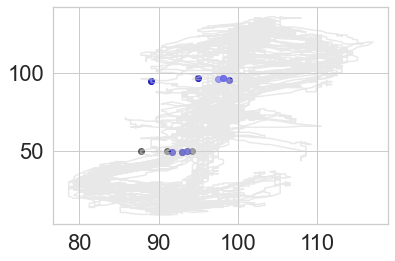

In [463]:
plt.plot(posdf['x'].values,posdf['y'].values,alpha=0.5,color='lightgrey')
plt.scatter(subpos_ins['x'].values,subpos_ins['y'].values,color='k',alpha=0.6)
plt.scatter(subpos_outs['x'].values,subpos_outs['y'].values,color='blue',alpha=0.6)

In [464]:
# plt.plot(posdf['x'].values,posdf['y'].values,alpha=0.5,color='lightgrey')
# plt.scatter(subrightcross_down['x'].values,subrightcross_down['y'].values,color='k',alpha=0.6)
# plt.scatter(subrightcross_up['x'].values,subrightcross_up['y'].values,color='teal',alpha=0.6)

# plt.scatter(subleftcross_up['x'].values,subleftcross_up['y'].values,color='red',alpha=0.6)
# plt.scatter(subleftcross_down['x'].values,subleftcross_down['y'].values,color='blue',alpha=0.6)

In [156]:
def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                     edgecolor='C0', fill=False, linewidth=1)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches